In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import gensim.parsing.preprocessing as gen_preproc

import spacy
nlp = spacy.load('en_core_web_sm')

import numpy as np
from gensim.models import FastText
from gensim.models import Word2Vec
from nltk.tokenize import sent_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.decomposition import TruncatedSVD

from sklearn import svm, tree
from sklearn.neural_network import MLPRegressor
from sklearn.linear_model import LinearRegression
from sklearn.naive_bayes import MultinomialNB

C:\Users\601969\Anaconda3\envs\nlp-bert-proj\lib\site-packages\gensim\similarities\__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


## Data Preview & Basic Cleanup

Simple open the file and preview the basic data in the training set.

In [3]:
df = pd.read_csv( 'parsed_train.txt', sep='\t', header=None,
                   names=['label', 'text'] )
df.head()

,label,text
0,__label__4,The Rock is destined to be the 21st Century 's...
1,__label__5,The gorgeously elaborate continuation of `` Th...
2,__label__4,Singer/composer Bryan Adams contributes a slew...
3,__label__3,You 'd think by now America would have had eno...
4,__label__4,Yet the act is still charming here .


Do some basic cleanup of labels, not yet preprocessing the text at all.

In [4]:
df['label'] = df['label'].apply(lambda x: int( x.replace("__label__", "") ) )

df.head()

,label,text
0,4,The Rock is destined to be the 21st Century 's...
1,5,The gorgeously elaborate continuation of `` Th...
2,4,Singer/composer Bryan Adams contributes a slew...
3,3,You 'd think by now America would have had eno...
4,4,Yet the act is still charming here .


#### Are my labels balanced and evenly distributed? 

Or do I need to pay special care to my input data?

(array([1092., 2218., 1624., 2322., 1288.]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

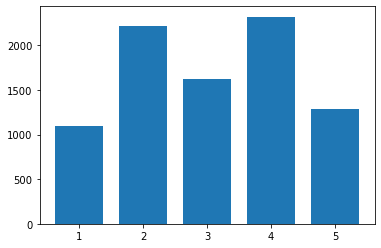

In [5]:
plt.hist(df['label'], bins=[1,2,3,4,5,6], align='left', rwidth=0.75)

A bit unbalanced, but not too much. Also a symetrical distrobution, not many extra positive or negative reviews; though theres slight more positive items.

#### How many reviews are more than a single sentence?

When getting to embedding models, can I treat each item as a single sentence? Based on the results, yes; nearly everything is a single sentence. 

(array([8.457e+03, 8.500e+01, 2.000e+00, 0.000e+00, 0.000e+00]),
 array([1, 2, 3, 4, 5, 6]),
 <BarContainer object of 5 artists>)

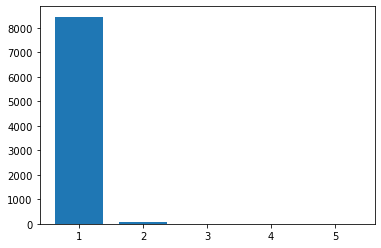

In [6]:
df['sentences'] = df['text'].apply(lambda x: len( sent_tokenize(x) ) )
plt.hist(df['sentences'], bins=[1,2,3,4,5,6], align='left', rwidth=0.75)

In [7]:
df2 = df.loc[df['sentences'] >= 2]
df2 = df2['text']
df2.head()

1      The gorgeously elaborate continuation of `` Th...
45     ... a sour little movie at its core ; an explo...
68     I walked away from this new version of E.T. ju...
199    As comedic spotlights go , Notorious C.H.O. hi...
537    E.T. works because its flabbergasting principa...
Name: text, dtype: object

## Preprocessing

Time to do a bit of preprocessing for different items. All items will be lowercase, punctuation & stop words stripped as well as some other basic preprocessing; plus one column thats stemmed and another lemmatized.

In [8]:
basicPreproc = [lambda x: x.lower(), gen_preproc.strip_tags, \
    gen_preproc.strip_punctuation, gen_preproc.strip_non_alphanum, \
    gen_preproc.strip_multiple_whitespaces] #, gen_preproc.strip_short, gen_preproc.remove_stopwords

df['basicProc'] = df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
df['stemmed'] = df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
df['lemmatized'] = df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

df.head()

,label,text,sentences,basicProc,stemmed,lemmatized
0,4,The Rock is destined to be the 21st Century 's...,1,the rock is destined to be the 21st century s ...,the rock is destin to be the 21st centuri s ne...,the rock be destine to be the 21st century s n...
1,5,The gorgeously elaborate continuation of `` Th...,2,the gorgeously elaborate continuation of the l...,the gorgeous elabor continu of the lord of the...,the gorgeously elaborate continuation of the l...
2,4,Singer/composer Bryan Adams contributes a slew...,1,singer composer bryan adams contributes a slew...,singer compos bryan adam contribut a slew of s...,singer composer bryan adams contribute a slew ...
3,3,You 'd think by now America would have had eno...,1,you d think by now america would have had enou...,you d think by now america would have had enou...,-PRON- d think by now america would have have ...
4,4,Yet the act is still charming here .,1,yet the act is still charming here,yet the act is still charm here,yet the act be still charm here


(array([ 726., 1370., 1754., 1430., 1430., 1028.,  439.,  249.,   95.,
          23.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

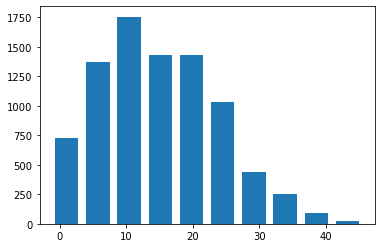

In [9]:
df['wordCount'] = df['lemmatized'].apply(lambda x: len(x.split()))
plt.hist(df['wordCount'], align='left', rwidth=0.75)

Unsurpisingly the distrobution is right skewed, though the tail is a bit shorter than expected still. Given that a relatively high percentage of reviews are short, I wonder how our predictions would get better if only juding on longer texts? 

## Creating BOW-Esk Input Vectors & Models

In [10]:
bowVec = CountVectorizer(binary=True, ngram_range=(1,2), min_df=2, max_features=5000)
cvVec = CountVectorizer(binary=False, ngram_range=(1,2), min_df=2, max_features=5000)
tfidfVec = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_features=5000)

bowDTM = bowVec.fit_transform(df['lemmatized'])
cvDTM = cvVec.fit_transform(df['lemmatized'])
tfidfDTM = tfidfVec.fit_transform(df['lemmatized'])

bowSVD = TruncatedSVD(n_components=300)
cvSVD = TruncatedSVD(n_components=300)
tfidfSVD = TruncatedSVD(n_components=300)

bow300DTM = bowSVD.fit_transform(bowDTM)
cv300DTM = cvSVD.fit_transform(cvDTM)
tfidf300DTM = tfidfSVD.fit_transform(tfidfDTM)

In [11]:
bowModel = svm.SVR()
cvModel = svm.SVR()
tfidfModel = svm.SVR()
bowSVDModel = svm.SVR()
cvSVDModel = svm.SVR()
tfidfSVDModel = svm.SVR()

bowModel.fit(bowDTM, df['label'])
cvModel.fit(cvDTM, df['label'])
tfidfModel.fit(tfidfDTM, df['label'])
bowSVDModel.fit(bow300DTM, df['label'])
cvSVDModel.fit(cv300DTM, df['label'])
tfidfSVDModel.fit(tfidf300DTM, df['label'])

SVR()

Trying some other models

In [12]:
bowModelSvm = svm.SVR()
bowModelNN = MLPRegressor(random_state=1, max_iter=200)
bowModelTree = tree.DecisionTreeRegressor()
bowModelLinReg = LinearRegression()
bowModelBayes = MultinomialNB() #Doesn't work w. negative values.

bowModelSvm.fit(bowDTM, df['label'])
bowModelNN.fit(bowDTM, df['label'])
bowModelTree.fit(bowDTM, df['label'])
bowModelLinReg.fit(bowDTM, df['label'])
bowModelBayes.fit(bowDTM, df['label'])

MultinomialNB()

## Load in the Test Dataset And Parse the same way as Train

In [13]:
test_df = pd.read_csv( 'parsed_test.txt', sep='\t', header=None,
                   names=['label', 'text'] )
test_df['label'] = test_df['label'].apply(lambda x: int( x.replace("__label__", "") ) )
test_df['basicProc'] = test_df['text'].apply(lambda x: ' '.join( gen_preproc.preprocess_string(x, basicPreproc)))
test_df['stemmed'] = test_df['basicProc'].apply(lambda x: gen_preproc.stem_text(x))
test_df['lemmatized'] = test_df['basicProc'].apply(lambda x: ' '.join( [token.lemma_ for token in nlp(x)] ) )

test_df.head()

,label,text,basicProc,stemmed,lemmatized
0,3,Effective but too-tepid biopic,effective but too tepid biopic,effect but too tepid biopic,effective but too tepid biopic
1,4,If you sometimes like to go to the movies to h...,if you sometimes like to go to the movies to h...,if you sometim like to go to the movi to have ...,if -PRON- sometimes like to go to the movie to...
2,5,"Emerges as something rare , an issue movie tha...",emerges as something rare an issue movie that ...,emerg as someth rare an issu movi that s so ho...,emerge as something rare an issue movie that s...
3,3,The film provides some great insight into the ...,the film provides some great insight into the ...,the film provid some great insight into the ne...,the film provide some great insight into the n...
4,5,Offers that rare combination of entertainment ...,offers that rare combination of entertainment ...,offer that rare combin of entertain and educ,offer that rare combination of entertainment a...


## BOW - Esk Evaluation

In [14]:
testBowDTM = bowVec.transform( test_df['lemmatized'] )
testCvDTM = cvVec.transform( test_df['lemmatized'] )
testTfidfDTM = tfidfVec.transform( test_df['lemmatized'] )

testBowSvdDTM = bowSVD.transform( testBowDTM )
testCvSvdDTM = cvSVD.transform( testCvDTM )
testTfidfSvdDTM = tfidfSVD.transform( testTfidfDTM )

In [15]:
print( 'Bow R^2: ',  bowModel.score( testBowDTM, test_df['label']) )
print( 'Cv R^2: ',  cvModel.score( testCvDTM, test_df['label'])  )
print( 'Tfidf R^2: ',  tfidfModel.score( testTfidfDTM, test_df['label'])  )

print( 'Bow SVD R^2: ',  bowSVDModel.score( testBowSvdDTM, test_df['label']) )
print( 'Cv SVD R^2: ',  cvSVDModel.score( testCvSvdDTM, test_df['label']) )
print( 'Tfidf SVD R^2: ',  tfidfSVDModel.score( testTfidfSvdDTM, test_df['label']) )

Bow R^2:  0.33200996559026075
Cv R^2:  0.3229852810198336
Tfidf R^2:  0.3627280831959865
Bow SVD R^2:  0.22824341553004335
Cv SVD R^2:  0.224378932650797
Tfidf SVD R^2:  0.29761311762636544


Fairly Comparable results amongst the SVM methods. Probably impacted by the fact that each text is relatively short. We didn't do any analysis of our actual vectorizer's here; technically we did keep max 5k vocab words but we don't know if we even hit that many. We don't know how sparse our input vectors are either. 

Very surprising that SVD accross the board made results significantly worse. I wonder why? Obviously it compresses information, but I would have guessed improved features would have been more important than not. As is clear, intuition is not always correct. Now time to examine our other methods.

In [16]:
print( 'Bow Neural Net R^2: ',  bowModelNN.score(testBowDTM, test_df['label']) )
print( 'Bow Tree R^2: ',  bowModelTree.score(testBowDTM, test_df['label']) )
print( 'Bow Linear Regression R^2: ',  bowModelLinReg.score(testBowDTM, test_df['label']) )
print( 'Bow Naive Bayes R^2: ',  bowModelBayes.score(testBowDTM, test_df['label']) )

Bow Neural Net R^2:  -0.0016589641529320964
Bow Tree R^2:  -0.34553119236286345
Bow Linear Regression R^2:  -0.3481873108439011
Bow Naive Bayes R^2:  0.39638009049773754


#### Lets look a little more in-depth at our results. 

Using confusion matrices, we * should hopefully * see that most of our errors are between adjacent classes. We can also further look at error Mean Square Error. Also wild that alot of the different algorithms have Negative R^2 values. The tree & linear regression in particular. Probably n-grams messing them up?

In [17]:
bowPredictions = bowModel.predict( testBowDTM )
cvPredictions = cvModel.predict( testCvDTM )
tfidfPredictions = tfidfModel.predict( testTfidfDTM )

bowSvdPredictions = bowSVDModel.predict( testBowSvdDTM )
cvSvdPredictions = cvSVDModel.predict( testCvSvdDTM )
tfidfSvdPredictions = tfidfSVDModel.predict( testTfidfSvdDTM )

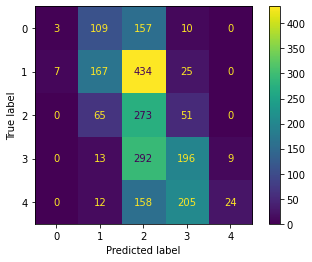

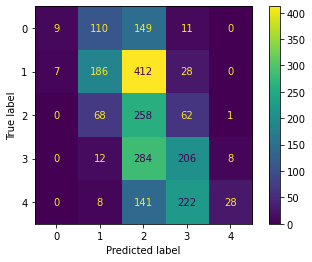

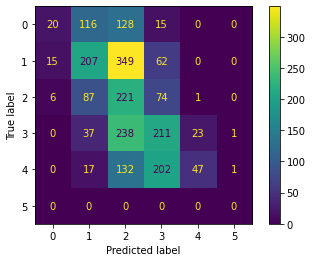

In [18]:
truth = test_df['label']
bowPredictions = [round( pred ) for pred in bowPredictions]
tfidfPredictions = [round( pred ) for pred in tfidfPredictions]
tfidfSvdPredictions = [round( pred ) for pred in tfidfSvdPredictions]

bowCM = confusion_matrix( truth, bowPredictions )
tfidfCM = confusion_matrix( truth, tfidfPredictions )
tfidfSvdCM = confusion_matrix( truth, tfidfSvdPredictions )
bowDisp = ConfusionMatrixDisplay( bowCM )
tfidfDisp = ConfusionMatrixDisplay( tfidfCM )
tfidfSvdDisp = ConfusionMatrixDisplay( tfidfSvdCM )
bowDisp.plot()
tfidfDisp.plot()
tfidfSvdDisp.plot()

We very clearly see that our models are all predicting neutral way too often. Perhaps some regression to the mean issue? Furthermore, all modesl are very bad at handling the outermost items, namely if the True label is 0|4 then the models are wrong a significant majority of the time. For the most part, we do at least stay within a good distance of the actual label (eg true 0's are very unlikely to be predicted as 4's or vice versa).

## Embedding Model Time

Here we are treating each doc (since they are very short) as a single sentence, just for simplicity. There's a tiny bit more data examination on the lengths of reviews, as we didn't need to tokenize until now.

(array([ 726., 1370., 1754., 1430., 1430., 1028.,  439.,  249.,   95.,
          23.]),
 array([ 1. ,  5.7, 10.4, 15.1, 19.8, 24.5, 29.2, 33.9, 38.6, 43.3, 48. ]),
 <BarContainer object of 10 artists>)

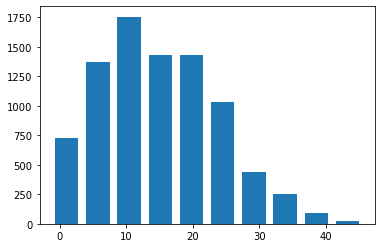

In [19]:
df['tokenized'] = df['lemmatized'].apply(lambda x: x.split())
w2vModel = Word2Vec( df['tokenized'], vector_size=100, window=5, min_count=3, workers=10)
w2vSvmModel = svm.SVR()

df['num_words'] = df['tokenized'].apply(lambda x: len(x))
plt.hist(df['num_words'], align='left', rwidth=0.75)

In [20]:
vocab = list(w2vModel.wv.index_to_key)

#Turns out with stop word removal some items have 0 words so deleted that out of preprocessing.
#Also turns out some items only have 2 word phrases, so deleted that out of preprocessing.
badsDf = df[df['tokenized'].apply(lambda x: len(x) < 1)] 
badsDf.head()

def calc_vec(tokensLst):
    vecs = [w2vModel.wv[word] for word in tokensLst if word in vocab]
    if len(vecs) == 0:
        vecs = [np.zeros(100), np.zeros(100)]
    return sum(vecs) / max([len(tokensLst), 1])

df['w2vVectors'] = df['tokenized'].apply(lambda x: calc_vec(x))
X = list( df['w2vVectors'] )
y = list( df['label'] )

w2vSvmModel.fit( X, y )

SVR()

In [21]:
test_df['tokenized'] = test_df['lemmatized'].apply(lambda x: x.split())
test_df['w2vVectors'] = test_df['tokenized'].apply(lambda x: calc_vec(x))
testX = list( test_df['w2vVectors'] )
testy = list( test_df['label'] )
w2vPredictions = w2vSvmModel.predict( testX )
w2vSvmModel.score( testX, testy )

0.03746779071683759

Interestingly, much worse performance than the non-embedding models. I wonder why?

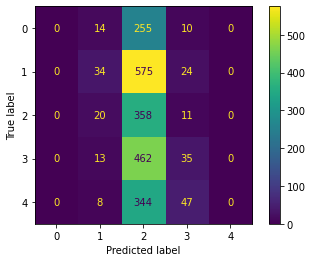

In [22]:
w2vPredictions = [round( pred ) for pred in w2vPredictions]
w2vCM = confusion_matrix( testy, w2vPredictions )
w2vDisp = ConfusionMatrixDisplay( w2vCM )
w2vDisp.plot()

Almost everythng is predicted as neutral...
This could very well be because we're drowning out the important words by averaging them, so everything is regressed towards the center, which is causing everything to be classified there as well. This time, lets attempt to feed in a matrix of w2v vectors instead of a single averages vector for our reviews.

In [28]:
def calc_matrix(tokensLst, max_words=35):
    empty = np.zeros(100)
    vecs = [w2vModel.wv[word] for word in tokensLst if word in vocab]
    if len(vecs) < max_words:
        vecs += [empty for i in range(len(vecs), max_words)]
    else:
        vecs = vecs[:max_words]
    vecs = np.array(vecs).flatten()
    return vecs

df['w2vMatrices'] = df['tokenized'].apply(lambda x: calc_matrix(x))
XMat = list( df['w2vMatrices'] )
y = list( df['label'] )

w2vMatModel = svm.SVR()
w2vMatModel.fit( XMat, y )
Xmat[0]

[-0.66571319  0.07679484 -0.24761917 ...  0.          0.
  0.        ]


In [37]:
len( XMat[0] )

3500

In [35]:
test_df['w2vMatrices'] = test_df['tokenized'].apply(lambda x: calc_matrix(x))
testMatX = list( test_df['w2vMatrices'] )

w2vMatPredictions = w2vMatModel.predict( testMatX )
w2vMatModel.score( testMatX, testy )

-0.010587043919003891

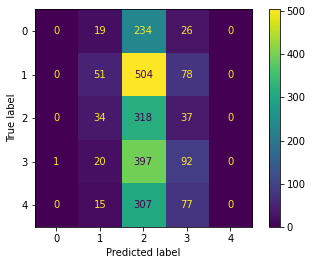

In [36]:
w2vMatPredictions = [round( pred ) for pred in w2vMatPredictions]
w2vMatCM = confusion_matrix( testy, w2vMatPredictions )
w2vMatDisp = ConfusionMatrixDisplay( w2vMatCM )
w2vMatDisp.plot()

## Potential Additions:

- Try FastText
- Compare results of stemming instead of lemmatization
- Use RMSE in addition to R^2 
- Include pretrained vectors